In [12]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

True
cuda


In [9]:
N_SAMPLES = 1000
RANDOM_STATE = 42
X, y = make_moons(n_samples=N_SAMPLES, random_state=RANDOM_STATE, noise=0.3)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = torch.from_numpy(X_train).float().to("cuda")
X_test = torch.from_numpy(X_test).float().to("cuda")
y_train = torch.from_numpy(y_train).float().to("cuda")
y_test = torch.from_numpy(y_test).float().to("cuda")



In [10]:
X_train, y_train

(tensor([[ 2.2360,  0.4705],
         [-1.3513,  0.4264],
         [-0.2783,  1.2589],
         ...,
         [-0.9431,  0.3833],
         [ 1.2209,  0.2535],
         [ 1.9510,  0.1674]], device='cuda:0'),
 tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
         1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
         1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
         0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1.,

In [13]:
table = {"X1": X[:, 0], "X2": X[:, 1], "label": y}
pd.DataFrame(table)

,X1,X2,label
0,-0.171863,0.596249,1
1,1.253283,-0.265414,1
2,0.723224,0.231943,1
3,-0.065198,-0.655194,1
4,-0.799493,0.552935,0
...,...,...,...
995,0.861014,0.343843,0
996,-0.229425,0.754849,0
997,1.770957,-0.509436,1
998,-1.061772,0.006786,0


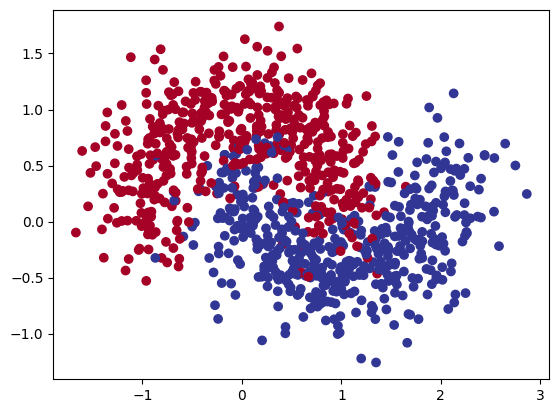

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [17]:
class MoonModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_layers):
        super().__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_layers),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            nn.Linear(in_features=hidden_layers, out_features=output_features)
        )
        
    def forward(self, x:torch.Tensor):
        return self.layer_stack(x)
    



model_0 = MoonModelV0(input_features=2, output_features=5, hidden_layers=10).to(device)

model_0.state_dict()
        

OrderedDict([('layer_stack.0.weight',
              tensor([[-0.1474, -0.0466],
                      [-0.1161,  0.6881],
                      [-0.1685,  0.4894],
                      [ 0.0483, -0.0395],
                      [ 0.0185,  0.2455],
                      [ 0.4019,  0.6116],
                      [-0.5729,  0.0794],
                      [-0.5417,  0.4512],
                      [ 0.5464,  0.0800],
                      [ 0.1128, -0.4079]], device='cuda:0')),
             ('layer_stack.0.bias',
              tensor([-0.0461,  0.5778,  0.1799, -0.3948, -0.4141,  0.2520, -0.0060,  0.0730,
                       0.3814, -0.2769], device='cuda:0')),
             ('layer_stack.1.weight',
              tensor([[ 0.2464,  0.2448, -0.2365,  0.0882,  0.0790, -0.2000, -0.2616, -0.1203,
                       -0.2471, -0.0488],
                      [-0.0282,  0.2411,  0.1049, -0.1850,  0.0505, -0.1258, -0.2891, -0.0873,
                       -0.0961,  0.0335],
                    